In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
import numpy as np

def BetaSchedule(n_steps, start=1e-4, end=0.02):
    """
    Generates a beta schedule for the forward process.
    """
    return np.linspace(start, end, n_steps)

def ForwardProcess(timesteps, initial_data):

    """
    Generates noised data using the forward process. Takes one random timestep
    generate a 1D noised data and store it in the noised_data array. This is repeated
    for each data point in the initial_data array.
    """

    ndata = len(initial_data)
    noised_data = np.zeros(ndata)
    noise = np.zeros(ndata)
    beta = BetaSchedule(timesteps)
    alpha = 1 - beta

    for i in range(ndata):

        time = np.random.randint(len(beta))
        noise[i] = np.random.normal(0,1)
        noised_data[i] = initial_data[i]*np.sqrt(np.prod(alpha[:i])) + (1 - np.prod(alpha[:i]))*noise[i]

    SaveCSV(noised_data, "noised_data")
    SaveCSV(noise, "noise")

    #return  noised_data, noise

def GenerateTwoDeltas(ndata):

    print(f"Generating two deltas distribution with {ndata} data points...")

    return np.concatenate([np.ones(ndata//2),-np.ones(ndata//2)])

def GenerateNoisedData(timesteps, ndata, initial_distribution):

    data = initial_distribution(ndata)

    print("forward process started...")

    ForwardProcess(timesteps, data)

    print("forward process ended...")


In [19]:
from torch.utils.data import TensorDataset
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def CreateDataloader(data,target):

  data_tensor = torch.tensor(data, dtype=torch.float32)
  target_tensor = torch.tensor(target, dtype=torch.float32)

  data_ds = TensorDataset(data_tensor,target_tensor)
  data_dl = DataLoader(data_ds, batch_size=100, shuffle=True)

  return data_dl

def Preprocessing(data, target):

  train_data_, test_data, train_target_, test_target = train_test_split(data, target, test_size=0.2)

  train_data, valid_data, train_target, valid_target = train_test_split(train_data_, train_target_, test_size=0.2)

  train_dl = CreateDataloader(train_data, train_target)
  valid_dl = CreateDataloader(valid_data, valid_target)
  test_dl = CreateDataloader(test_data, test_target)

  return train_dl, valid_dl, test_dl

def SaveCSV(data, name):

   df_data = pd.DataFrame(data)
   df_data.to_csv( name + ".csv", index=False, header=False)

def LoadCSV(name):
   return pd.read_csv( name + ".csv", header=None).values.flatten()

In [20]:
GenerateNoisedData(300, 1000, GenerateTwoDeltas)

Generating two deltas distribution with 1000 data points...
forward process started...
forward process ended...


In [21]:
import torch.nn as nn

class FeedForward(nn.Module):

  def __init__(self, input_size, output_size,n_hidden_layers,depht):
    super().__init__()

    l = [nn.Linear(input_size,depht), nn.ReLU()]
    i = 0
    while i < n_hidden_layers:
      l.append(nn.Linear(depht, depht))
      l.append(nn.ReLU())
      i+=1
    l.append(nn.Linear(depht, output_size))
    self.model_list = nn.ModuleList(l)

  def forward(self,x):
    for layer in self.model_list:
      x = layer(x)
    return x

In [28]:
def Train(learning_rate,model,num_epochs,train_dl,valid_dl, patience=5, min_delta=0.001,):

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    loss_hist_train = np.zeros(num_epochs)
    loss_hist_valid = np.zeros(num_epochs)

    # Variables for early stopping

    #best_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):

      model.train()  # Set model to training mode
      train_loss = 0.0

      for x_batch, y_batch in train_dl:

        x = x_batch.view(x_batch.size(0), -1).detach().clone().requires_grad_(True)
        y = y_batch.view(y_batch.size(0), -1).detach().clone().requires_grad_(True)

        pred = model(x)
            #Define loss function
        loss = loss_fn(pred, y)
            #Backpropagation
        loss.backward()
            #Apply gradient to the weights
        optimizer.step()
            #Make gradients zero
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()*y_batch.size(0)

      for x_batch, y_batch in valid_dl:

        x = x_batch.view(x_batch.size(0), -1).detach().clone().requires_grad_(True)
        y = y_batch.view(y_batch.size(0), -1).detach().clone().requires_grad_(True)

        pred = model(x)
        loss = loss_fn(pred, y)

        loss_hist_valid[epoch] += loss.item()*y_batch.size(0)

      loss_hist_train[epoch] /= len(train_dl.dataset)
      loss_hist_valid[epoch] /= len(valid_dl.dataset)

      #if loss_hist_valid[epoch] < best_loss - min_delta:
        #best_loss = loss_hist_valid[epoch]
        #epochs_no_improve = 0
        #best_model_state = model.state_dict()  # Save the best model
      #else:
      #  epochs_no_improve += 1

      #if epochs_no_improve >= patience:
        #print(f'Early stopping triggered after {epoch+1} epochs!')
        #model.load_state_dict(best_model_state)  # Restore best model
        #final_epoch = epoch
        #break

    #loss_hist_train = loss_hist_train[:final_epoch+1]
    #loss_hist_valid = loss_hist_valid[:final_epoch+1]

    return loss_hist_train, loss_hist_valid

def TrainModel(num_epochs, learning_rate):

    model = FeedForward(input_size=1,output_size=1,n_hidden_layers=2,depht=100)

    noised_data, noise = LoadCSV("noised_data"), LoadCSV("noise")
    train_dl, valid_dl, test_dl = Preprocessing(noised_data, noise)

    loss_hist_train,loss_hist_valid = Train(learning_rate=learning_rate, model=model, num_epochs=num_epochs,
                                           train_dl=train_dl, valid_dl=valid_dl
                                           )

    return model, loss_hist_train, loss_hist_valid

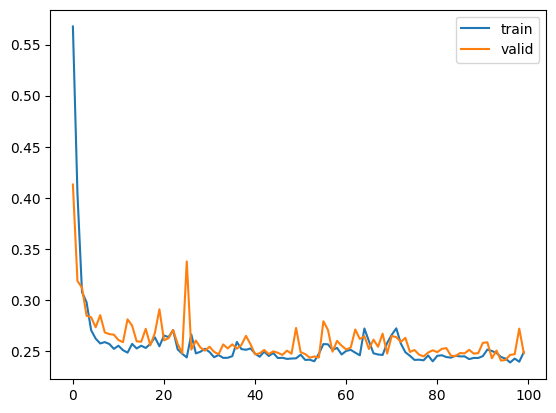

In [29]:
model, loss_hist_train, loss_hist_valid = TrainModel(100, learning_rate=0.01)

plt.plot(loss_hist_train, label='train')
plt.plot(loss_hist_valid, label='valid')
plt.legend()

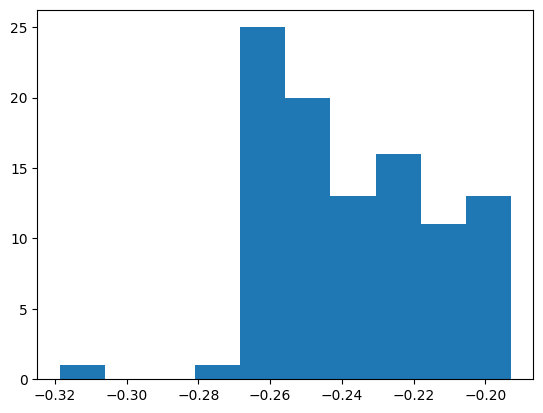

In [43]:
model = FeedForward(input_size=1,output_size=1,n_hidden_layers=1,depht=100)

noised_data, noise = LoadCSV("noised_data"), LoadCSV("noise")
train_dl, valid_dl, test_dl = Preprocessing(noised_data, noise)




for x_batch, y_batch in train_dl:
  x = x_batch.view(x_batch.size(0), -1).detach().clone().requires_grad_(True)
  y = y_batch.view(y_batch.size(0), -1).detach().clone().requires_grad_(True)

  plt.hist(model(x).detach().numpy())

  break




In [41]:
print(model)

FeedForward(
  (model_list): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)
